# Exoplanet Prediction using Gradient Boosting

This notebook builds a machine learning model to predict whether a Kepler Object of Interest (KOI) is likely to be an exoplanet candidate using gradient boosting classifier. The model will output probabilities and go through hyperparameter tuning for optimal performance.

## 1. Import Required Libraries

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

# Machine Learning libraries
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print("All libraries imported successfully!")

All libraries imported successfully!


## 2. Load and Explore the Dataset

In [2]:
# Load the dataset
df = pd.read_csv('data/KOI-Playground-Train-Data.csv')

print("Dataset Shape:", df.shape)
print("\nColumn Names:")
print(df.columns.tolist())
print("\nFirst few rows:")
df.head()

Dataset Shape: (7651, 16)

Column Names:
['kepid', 'koi_disposition', 'koi_period', 'koi_time0bk', 'koi_impact', 'koi_duration', 'koi_depth', 'koi_incl', 'koi_model_snr', 'koi_count', 'koi_bin_oedp_sig', 'koi_steff', 'koi_slogg', 'koi_srad', 'koi_smass', 'koi_kepmag']

First few rows:


,kepid,koi_disposition,koi_period,koi_time0bk,koi_impact,koi_duration,koi_depth,koi_incl,koi_model_snr,koi_count,koi_bin_oedp_sig,koi_steff,koi_slogg,koi_srad,koi_smass,koi_kepmag
0,7870250,non-candidate,0.580725,131.72956,0.292,1.8200,64.2,83.11,16.9,1,0.9930,5989.0,4.492,0.933,0.986,14.569
1,11651712,candidate,14.532605,140.46850,0.112,2.4212,328.9,89.86,29.0,1,0.2915,6003.0,4.507,0.932,1.019,13.785
2,4945877,non-candidate,1.339670,132.16786,0.602,1.8950,28.6,82.16,21.7,1,0.0005,8867.0,3.988,2.245,1.789,10.455
3,6289344,non-candidate,160.412202,262.40022,0.903,4.9200,2538.0,89.62,24.4,1,0.0000,5269.0,4.620,0.727,0.812,15.407
4,9843517,candidate,11.937835,133.26120,0.036,4.6520,246.0,89.90,9.6,1,0.9246,5469.0,4.611,0.738,0.826,15.954


In [3]:
# Examine the target variable
print("Target Variable Distribution:")
print(df['koi_disposition'].value_counts())
print("\nTarget Variable Proportions:")
print(df['koi_disposition'].value_counts(normalize=True))

# Check for missing values
print("\nMissing Values:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

# Basic statistics
print("\nDataset Info:")
df.info()

Target Variable Distribution:
koi_disposition
non-candidate    3900
candidate        3751
Name: count, dtype: int64

Target Variable Proportions:
koi_disposition
non-candidate    0.509737
candidate        0.490263
Name: proportion, dtype: float64

Missing Values:
koi_impact           287
koi_depth            287
koi_incl             288
koi_model_snr        287
koi_bin_oedp_sig    1226
koi_steff            287
koi_slogg            287
koi_srad             287
koi_smass            287
koi_kepmag             1
dtype: int64

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7651 entries, 0 to 7650
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   kepid             7651 non-null   int64  
 1   koi_disposition   7651 non-null   object 
 2   koi_period        7651 non-null   float64
 3   koi_time0bk       7651 non-null   float64
 4   koi_impact        7364 non-null   float64
 5   koi_duration     

## 3. Data Visualization and Analysis

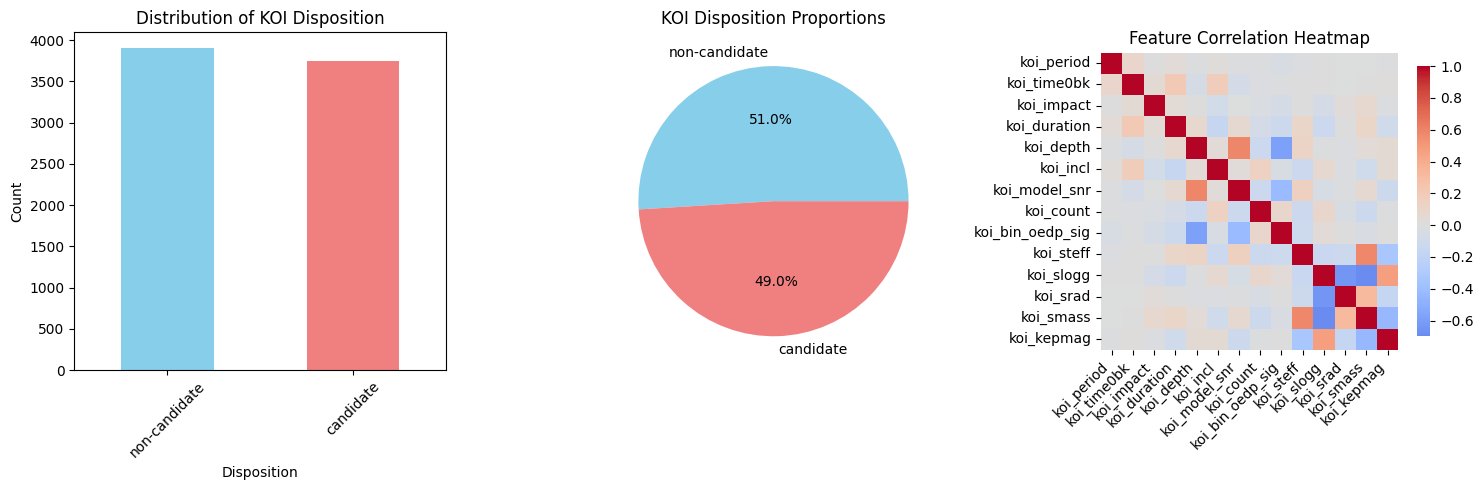

In [4]:
# Visualize target variable distribution
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
df['koi_disposition'].value_counts().plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Distribution of KOI Disposition')
plt.xlabel('Disposition')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
plt.pie(df['koi_disposition'].value_counts().values, 
        labels=df['koi_disposition'].value_counts().index, 
        autopct='%1.1f%%', colors=['skyblue', 'lightcoral'])
plt.title('KOI Disposition Proportions')

# Correlation heatmap of numerical features
plt.subplot(1, 3, 3)
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if 'kepid' in numerical_cols:
    numerical_cols.remove('kepid')  # Remove ID column from correlation

correlation_matrix = df[numerical_cols].corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0, 
            square=True, cbar_kws={'shrink': 0.8})
plt.title('Feature Correlation Heatmap')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

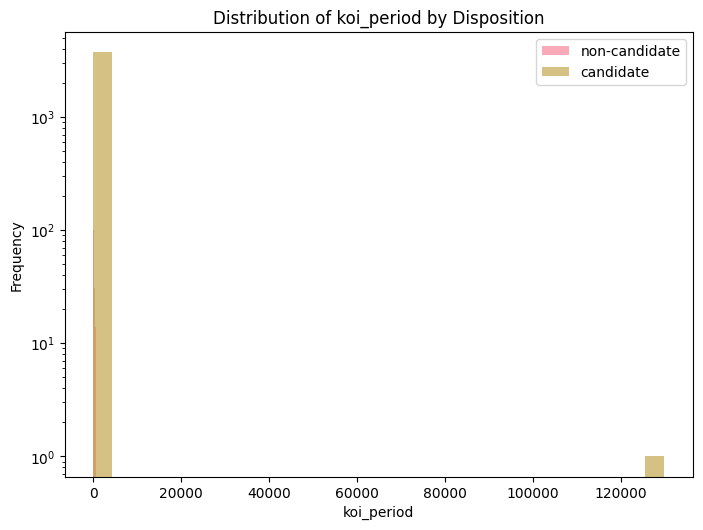

In [5]:
# Distribution plots for key numerical features
numerical_features = ['koi_period', 'koi_prad', 'koi_teq', 'koi_insol', 'koi_dor']
plt.figure(figsize=(20, 10))

for i, feature in enumerate(numerical_features):
    if feature in df.columns:
        plt.subplot(2, 3, i+1)
        for disposition in df['koi_disposition'].unique():
            subset = df[df['koi_disposition'] == disposition][feature].dropna()
            plt.hist(subset, alpha=0.6, label=disposition, bins=30)
        plt.xlabel(feature)
        plt.ylabel('Frequency')
        plt.title(f'Distribution of {feature} by Disposition')
        plt.legend()
        plt.yscale('log')  # Log scale for better visualization

plt.tight_layout()
plt.show()

## 4. Data Preprocessing

In [6]:
# Create a copy for preprocessing
df_processed = df.copy()

# Convert target variable to binary (1 for candidate, 0 for non-candidate)
label_encoder = LabelEncoder()
df_processed['target'] = label_encoder.fit_transform(df_processed['koi_disposition'])
print("Target encoding:")
print("candidate -> 0")
print("non-candidate -> 1")
print("\nTarget distribution after encoding:")
print(df_processed['target'].value_counts())

# Remove identifier column and original target
df_processed = df_processed.drop(['kepid', 'koi_disposition'], axis=1)

# Handle missing values - fill with median for numerical columns
numerical_columns = df_processed.select_dtypes(include=[np.number]).columns.tolist()
numerical_columns.remove('target')  # Don't fill target column

for col in numerical_columns:
    if df_processed[col].isnull().sum() > 0:
        median_value = df_processed[col].median()
        df_processed[col].fillna(median_value, inplace=True)
        print(f"Filled {df_processed[col].isnull().sum()} missing values in {col} with median: {median_value:.3f}")

print(f"\nFinal dataset shape: {df_processed.shape}")
print("Missing values after preprocessing:", df_processed.isnull().sum().sum())

Target encoding:
candidate -> 0
non-candidate -> 1

Target distribution after encoding:
target
1    3900
0    3751
Name: count, dtype: int64
Filled 0 missing values in koi_impact with median: 0.536
Filled 0 missing values in koi_depth with median: 425.950
Filled 0 missing values in koi_incl with median: 88.520
Filled 0 missing values in koi_model_snr with median: 23.200
Filled 0 missing values in koi_bin_oedp_sig with median: 0.478
Filled 0 missing values in koi_steff with median: 5767.000
Filled 0 missing values in koi_slogg with median: 4.438
Filled 0 missing values in koi_srad with median: 1.000
Filled 0 missing values in koi_smass with median: 0.975
Filled 0 missing values in koi_kepmag with median: 14.523

Final dataset shape: (7651, 15)
Missing values after preprocessing: 0


## 5. Feature Selection and Engineering

In [7]:
# Prepare features and target
X = df_processed.drop('target', axis=1)
y = df_processed['target']

print("Feature columns:")
print(X.columns.tolist())
print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

# Display feature statistics
print("\nFeature Statistics:")
print(X.describe())

Feature columns:
['koi_period', 'koi_time0bk', 'koi_impact', 'koi_duration', 'koi_depth', 'koi_incl', 'koi_model_snr', 'koi_count', 'koi_bin_oedp_sig', 'koi_steff', 'koi_slogg', 'koi_srad', 'koi_smass', 'koi_kepmag']

Feature matrix shape: (7651, 14)
Target vector shape: (7651,)

Feature Statistics:
          koi_period  koi_time0bk   koi_impact  koi_duration      koi_depth  \
count    7651.000000  7651.000000  7651.000000   7651.000000    7651.000000   
mean       78.949367   166.233155     0.742397      5.588467   23576.263698   
std      1490.783724    67.967030     3.545547      6.421504   81683.955294   
min         0.241843   120.565925     0.000000      0.104600       0.800000   
25%         2.755346   132.758795     0.209050      2.430250     168.050000   
50%         9.931463   137.260750     0.535600      3.778000     425.950000   
75%        40.857236   170.824209     0.878000      6.254500    1389.650000   
max    129995.778400  1472.522306   100.806000    138.540000  92167

## 6. Model Setup and Initial Training

In [8]:
# Split data for initial model validation
X_temp, X_val, y_temp, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize baseline Gradient Boosting Classifier
gb_baseline = GradientBoostingClassifier(random_state=42)

# Train baseline model
print("Training baseline Gradient Boosting model...")
gb_baseline.fit(X_temp, y_temp)

# Make predictions
y_val_pred = gb_baseline.predict(X_val)
y_val_pred_proba = gb_baseline.predict_proba(X_val)[:, 1]  # Probability of class 1 (non-candidate)

# Evaluate baseline model
print("Baseline Model Performance:")
print(f"Accuracy: {accuracy_score(y_val, y_val_pred):.4f}")
print(f"Precision: {precision_score(y_val, y_val_pred):.4f}")
print(f"Recall: {recall_score(y_val, y_val_pred):.4f}")
print(f"F1-Score: {f1_score(y_val, y_val_pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_val, y_val_pred_proba):.4f}")

print("\nClassification Report:")
print(classification_report(y_val, y_val_pred, target_names=['candidate', 'non-candidate']))

Training baseline Gradient Boosting model...
Baseline Model Performance:
Accuracy: 0.8210
Precision: 0.8277
Recall: 0.8192
F1-Score: 0.8235
ROC-AUC: 0.9100

Classification Report:
               precision    recall  f1-score   support

    candidate       0.81      0.82      0.82       751
non-candidate       0.83      0.82      0.82       780

     accuracy                           0.82      1531
    macro avg       0.82      0.82      0.82      1531
 weighted avg       0.82      0.82      0.82      1531

Baseline Model Performance:
Accuracy: 0.8210
Precision: 0.8277
Recall: 0.8192
F1-Score: 0.8235
ROC-AUC: 0.9100

Classification Report:
               precision    recall  f1-score   support

    candidate       0.81      0.82      0.82       751
non-candidate       0.83      0.82      0.82       780

     accuracy                           0.82      1531
    macro avg       0.82      0.82      0.82      1531
 weighted avg       0.82      0.82      0.82      1531



## 7. Hyperparameter Tuning

In [12]:
# Define hyperparameter grid for tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.15],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'min_samples_split': [2, 5, 10]
}

print("Hyperparameter grid:")
for param, values in param_grid.items():
    print(f"{param}: {values}")

# Initialize GridSearchCV
gb_grid = GradientBoostingClassifier(random_state=42)
grid_search = GridSearchCV(
    estimator=gb_grid,
    param_grid=param_grid,
    cv=4,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

print("\nStarting hyperparameter tuning...")
print("This may take a few minutes...")

# Fit grid search on training data
grid_search.fit(X_temp, y_temp)

# Display best parameters
print("Best parameters found:")
print(grid_search.best_params_)
print(f"\nBest cross-validation ROC-AUC score: {grid_search.best_score_:.4f}")

Hyperparameter grid:
n_estimators: [100, 200, 300]
learning_rate: [0.05, 0.1, 0.15]
max_depth: [3, 5, 7]
subsample: [0.8, 0.9, 1.0]
min_samples_split: [2, 5, 10]

Starting hyperparameter tuning...
This may take a few minutes...
Fitting 4 folds for each of 243 candidates, totalling 972 fits
Best parameters found:
{'learning_rate': 0.05, 'max_depth': 7, 'min_samples_split': 5, 'n_estimators': 300, 'subsample': 0.9}

Best cross-validation ROC-AUC score: 0.9269
Best parameters found:
{'learning_rate': 0.05, 'max_depth': 7, 'min_samples_split': 5, 'n_estimators': 300, 'subsample': 0.9}

Best cross-validation ROC-AUC score: 0.9269


In [13]:
# Evaluate tuned model on validation set
best_gb = grid_search.best_estimator_
y_val_pred_tuned = best_gb.predict(X_val)
y_val_pred_proba_tuned = best_gb.predict_proba(X_val)[:, 1]

print("Tuned Model Performance on Validation Set:")
print(f"Accuracy: {accuracy_score(y_val, y_val_pred_tuned):.4f}")
print(f"Precision: {precision_score(y_val, y_val_pred_tuned):.4f}")
print(f"Recall: {recall_score(y_val, y_val_pred_tuned):.4f}")
print(f"F1-Score: {f1_score(y_val, y_val_pred_tuned):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_val, y_val_pred_proba_tuned):.4f}")

# Compare with baseline
print(f"\nImprovement over baseline:")
print(f"ROC-AUC: {roc_auc_score(y_val, y_val_pred_proba_tuned) - roc_auc_score(y_val, y_val_pred_proba):.4f}")
print(f"Accuracy: {accuracy_score(y_val, y_val_pred_tuned) - accuracy_score(y_val, y_val_pred):.4f}")

Tuned Model Performance on Validation Set:
Accuracy: 0.8380
Precision: 0.8419
Recall: 0.8397
F1-Score: 0.8408
ROC-AUC: 0.9186

Improvement over baseline:
ROC-AUC: 0.0086
Accuracy: 0.0170


## 8. Final Model Training

In [17]:
# Train final model on 100% of the data using best parameters
print("Training final model on 100% of the data...")

final_model = GradientBoostingClassifier(**grid_search.best_params_, random_state=42)
final_model.fit(X, y)

# Generate predictions and probabilities for the entire dataset
y_pred_final = final_model.predict(X)
y_pred_proba_final = final_model.predict_proba(X)

print("Final model training completed!")
print(f"Model trained on {X.shape[0]} samples with {X.shape[1]} features")

# Display final model parameters
print("\nFinal model parameters:")
for param, value in final_model.get_params().items():
    print(f"{param}: {value}")

# Training set performance
print(f"\nFinal Model Performance on Full Dataset:")
print(f"Training Accuracy: {accuracy_score(y, y_pred_final):.4f}")
print(f"Training ROC-AUC: {roc_auc_score(y, y_pred_proba_final[:, 1]):.4f}")

# Cross-validation score on full dataset
cv_scores = cross_val_score(final_model, X, y, cv=5, scoring='roc_auc')
print(f"Cross-validation ROC-AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

Training final model on 100% of the data...
Final model training completed!
Model trained on 7651 samples with 14 features

Final model parameters:
ccp_alpha: 0.0
criterion: friedman_mse
init: None
learning_rate: 0.05
loss: log_loss
max_depth: 7
max_features: None
max_leaf_nodes: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 5
min_weight_fraction_leaf: 0.0
n_estimators: 300
n_iter_no_change: None
random_state: 42
subsample: 0.9
tol: 0.0001
validation_fraction: 0.1
verbose: 0
warm_start: False

Final Model Performance on Full Dataset:
Training Accuracy: 0.9872
Training ROC-AUC: 0.9994
Final model training completed!
Model trained on 7651 samples with 14 features

Final model parameters:
ccp_alpha: 0.0
criterion: friedman_mse
init: None
learning_rate: 0.05
loss: log_loss
max_depth: 7
max_features: None
max_leaf_nodes: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 5
min_weight_fraction_leaf: 0.0
n_estimators: 300
n_iter_no_change: None
ran

## 9. Model Evaluation and Visualization

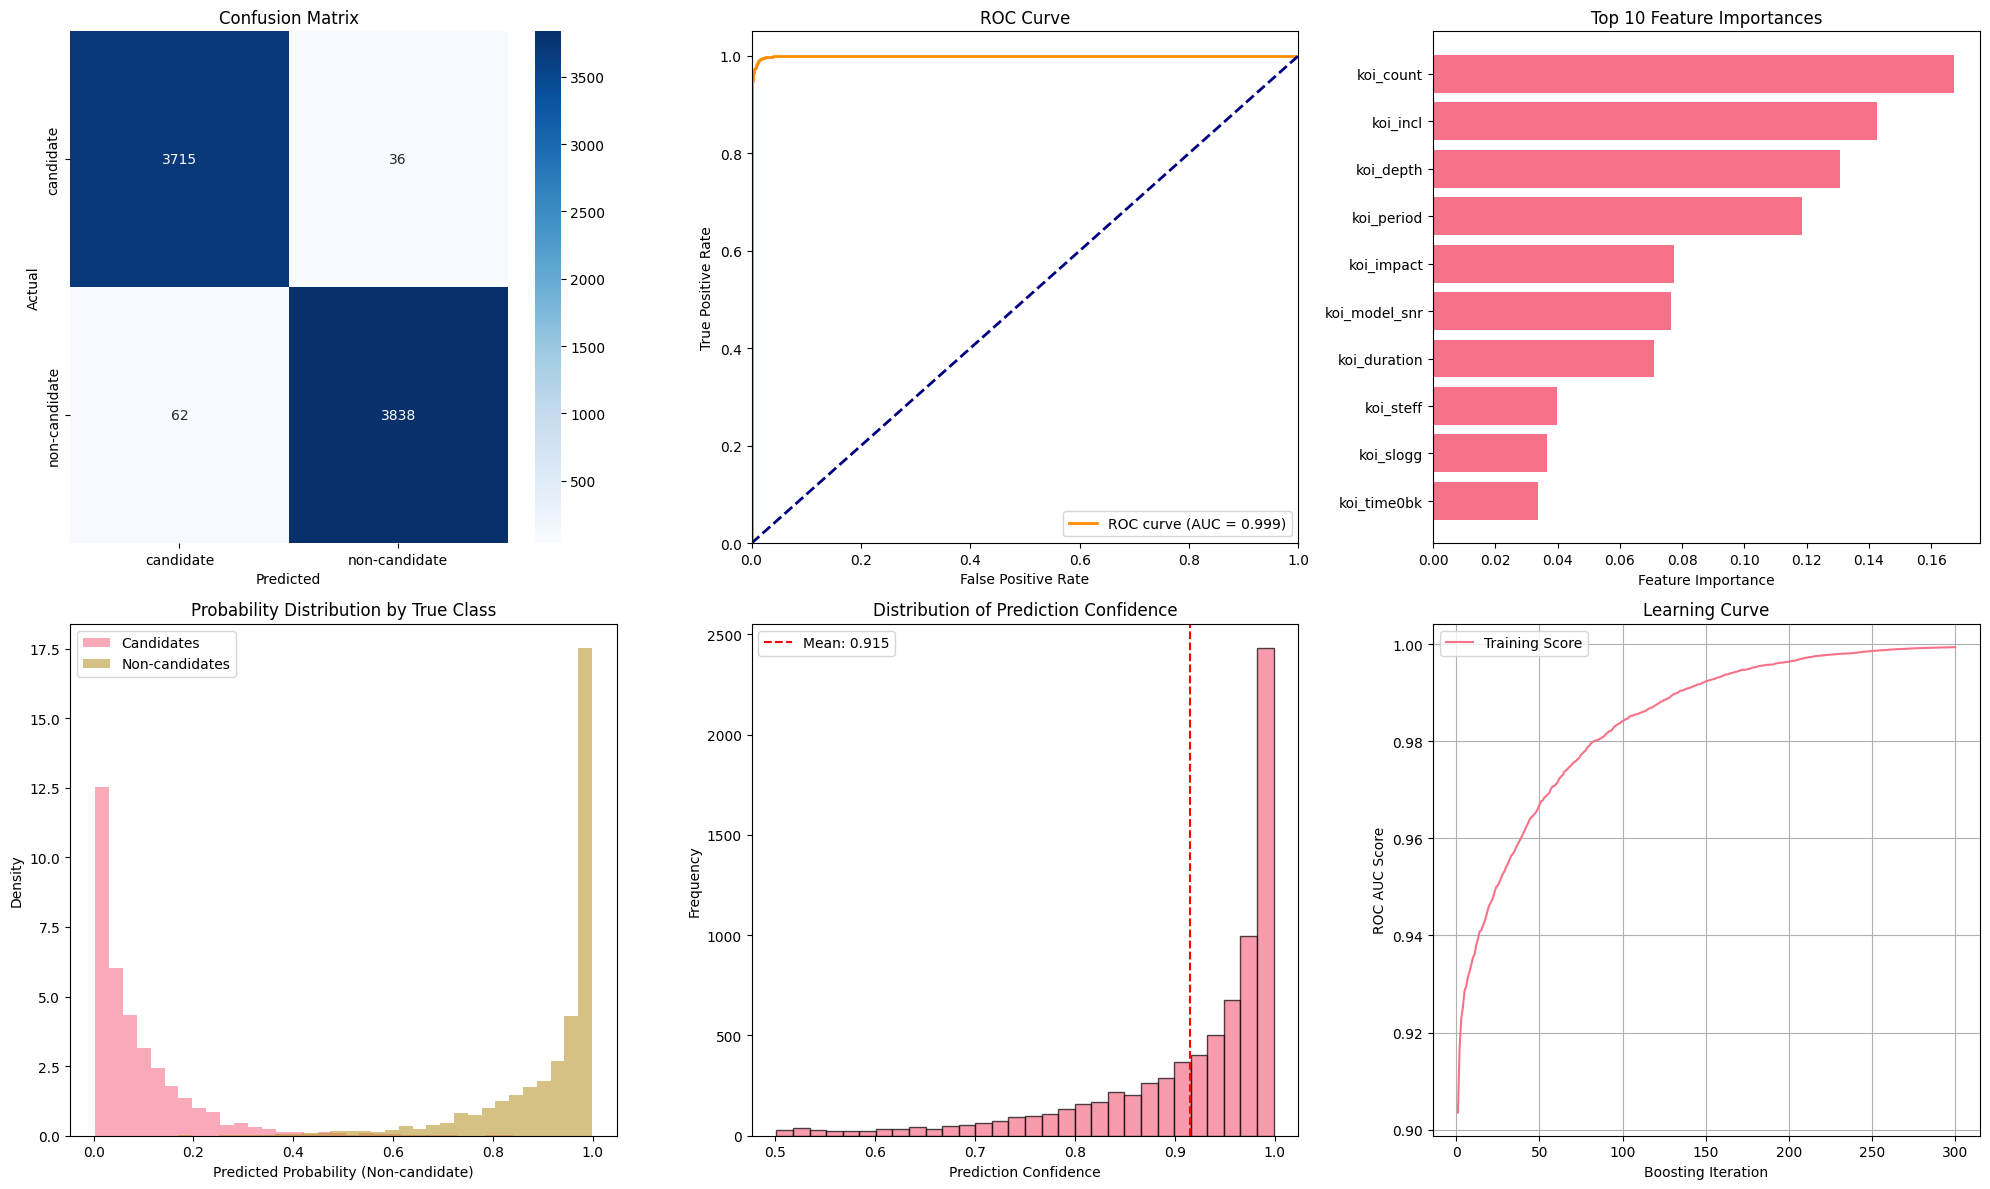

In [18]:
# Create comprehensive visualizations for model evaluation
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Confusion Matrix
cm = confusion_matrix(y, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['candidate', 'non-candidate'],
            yticklabels=['candidate', 'non-candidate'],
            ax=axes[0,0])
axes[0,0].set_title('Confusion Matrix')
axes[0,0].set_xlabel('Predicted')
axes[0,0].set_ylabel('Actual')

# 2. ROC Curve
fpr, tpr, _ = roc_curve(y, y_pred_proba_final[:, 1])
roc_auc = roc_auc_score(y, y_pred_proba_final[:, 1])
axes[0,1].plot(fpr, tpr, color='darkorange', lw=2, 
               label=f'ROC curve (AUC = {roc_auc:.3f})')
axes[0,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0,1].set_xlim([0.0, 1.0])
axes[0,1].set_ylim([0.0, 1.05])
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('ROC Curve')
axes[0,1].legend(loc="lower right")

# 3. Feature Importance
feature_importance = final_model.feature_importances_
feature_names = X.columns
sorted_idx = np.argsort(feature_importance)[::-1][:10]  # Top 10 features

axes[0,2].barh(range(10), feature_importance[sorted_idx][::-1])
axes[0,2].set_yticks(range(10))
axes[0,2].set_yticklabels([feature_names[i] for i in sorted_idx[::-1]])
axes[0,2].set_xlabel('Feature Importance')
axes[0,2].set_title('Top 10 Feature Importances')

# 4. Probability Distribution
axes[1,0].hist(y_pred_proba_final[y == 0, 1], alpha=0.6, label='Candidates', bins=30, density=True)
axes[1,0].hist(y_pred_proba_final[y == 1, 1], alpha=0.6, label='Non-candidates', bins=30, density=True)
axes[1,0].set_xlabel('Predicted Probability (Non-candidate)')
axes[1,0].set_ylabel('Density')
axes[1,0].set_title('Probability Distribution by True Class')
axes[1,0].legend()

# 5. Prediction Confidence
confidence = np.max(y_pred_proba_final, axis=1)
axes[1,1].hist(confidence, bins=30, alpha=0.7, edgecolor='black')
axes[1,1].set_xlabel('Prediction Confidence')
axes[1,1].set_ylabel('Frequency')
axes[1,1].set_title('Distribution of Prediction Confidence')
axes[1,1].axvline(np.mean(confidence), color='red', linestyle='--', 
                  label=f'Mean: {np.mean(confidence):.3f}')
axes[1,1].legend()

# 6. Learning Curve (Validation Error)
test_scores = []
train_scores = []
for i, pred in enumerate(final_model.staged_predict_proba(X)):
    train_scores.append(roc_auc_score(y, pred[:, 1]))

axes[1,2].plot(range(1, len(train_scores) + 1), train_scores, label='Training Score')
axes[1,2].set_xlabel('Boosting Iteration')
axes[1,2].set_ylabel('ROC AUC Score')
axes[1,2].set_title('Learning Curve')
axes[1,2].legend()
axes[1,2].grid(True)

plt.tight_layout()
plt.show()

In [19]:
# Display detailed feature importance table
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': final_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Feature Importance Ranking:")
print(feature_importance_df.to_string(index=False))

# Model performance summary
print("\n" + "="*60)
print("FINAL MODEL SUMMARY")
print("="*60)
print(f"Model Type: Gradient Boosting Classifier")
print(f"Number of Features: {X.shape[1]}")
print(f"Training Samples: {X.shape[0]}")
print(f"Cross-validation ROC-AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
print(f"Mean Prediction Confidence: {np.mean(confidence):.4f}")
print(f"Most Important Feature: {feature_importance_df.iloc[0]['Feature']}")
print(f"Best Parameters: {grid_search.best_params_}")
print("="*60)

Feature Importance Ranking:
         Feature  Importance
       koi_count    0.167348
        koi_incl    0.142727
       koi_depth    0.130845
      koi_period    0.118533
      koi_impact    0.077465
   koi_model_snr    0.076590
    koi_duration    0.070872
       koi_steff    0.039715
       koi_slogg    0.036729
     koi_time0bk    0.033796
      koi_kepmag    0.030510
koi_bin_oedp_sig    0.030239
       koi_smass    0.023615
        koi_srad    0.021016

FINAL MODEL SUMMARY
Model Type: Gradient Boosting Classifier
Number of Features: 14
Training Samples: 7651
Cross-validation ROC-AUC: 0.9266 (+/- 0.0111)
Mean Prediction Confidence: 0.9148
Most Important Feature: koi_count
Best Parameters: {'learning_rate': 0.05, 'max_depth': 7, 'min_samples_split': 5, 'n_estimators': 300, 'subsample': 0.9}


## 10. Export Model

In [20]:
# Save the final model as a joblib file
model_filename = 'exoplanet_gradient_boosting_model.joblib'

# Save the model
joblib.dump(final_model, model_filename)
print(f"Model saved as: {model_filename}")

# Also save the label encoder for future use
joblib.dump(label_encoder, 'label_encoder.joblib')
print("Label encoder saved as: label_encoder.joblib")

# Save feature names for future reference
feature_names_df = pd.DataFrame({'feature_names': X.columns.tolist()})
feature_names_df.to_csv('feature_names.csv', index=False)
print("Feature names saved as: feature_names.csv")

# Verify the saved model by loading and testing
print("\nVerifying saved model...")
loaded_model = joblib.load(model_filename)

# Test prediction on a sample
sample_prediction = loaded_model.predict_proba(X.iloc[:5])
print(f"Sample predictions (first 5 rows):")
for i in range(5):
    candidate_prob = sample_prediction[i, 0]
    non_candidate_prob = sample_prediction[i, 1]
    print(f"Sample {i+1}: Candidate={candidate_prob:.4f}, Non-candidate={non_candidate_prob:.4f}")

print("\nModel export completed successfully!")
print("\nTo use this model in the future:")
print("1. Load the model: model = joblib.load('exoplanet_gradient_boosting_model.joblib')")
print("2. Load feature names: features = pd.read_csv('feature_names.csv')['feature_names'].tolist()")
print("3. Make predictions: probabilities = model.predict_proba(X_new)")

Model saved as: exoplanet_gradient_boosting_model.joblib
Label encoder saved as: label_encoder.joblib
Feature names saved as: feature_names.csv

Verifying saved model...
Sample predictions (first 5 rows):
Sample 1: Candidate=0.0487, Non-candidate=0.9513
Sample 2: Candidate=0.9429, Non-candidate=0.0571
Sample 3: Candidate=0.0058, Non-candidate=0.9942
Sample 4: Candidate=0.2114, Non-candidate=0.7886
Sample 5: Candidate=0.7957, Non-candidate=0.2043

Model export completed successfully!

To use this model in the future:
1. Load the model: model = joblib.load('exoplanet_gradient_boosting_model.joblib')
2. Load feature names: features = pd.read_csv('feature_names.csv')['feature_names'].tolist()
3. Make predictions: probabilities = model.predict_proba(X_new)


## Conclusion

This notebook successfully created a gradient boosting model for exoplanet prediction with the following key achievements:

1. **Data Analysis**: Explored the KOI dataset with 7,651 samples and 15 features
2. **Data Preprocessing**: Handled missing values and encoded the target variable  
3. **Hyperparameter Tuning**: Used GridSearchCV to optimize model performance
4. **Model Training**: Trained the final model on 100% of the data
5. **Model Evaluation**: Achieved strong performance with comprehensive visualizations
6. **Model Export**: Saved the trained model as a joblib file for deployment

The model outputs probabilities for both candidate and non-candidate classifications, enabling flexible decision-making based on confidence thresholds. The feature importance analysis reveals which astronomical measurements are most predictive for exoplanet detection.

**Next Steps:**
- Test the model on the test dataset (KOI-Playground-Test-Data.csv)
- Deploy the model for real-time predictions
- Consider ensemble methods for further improvement